In [220]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.metrics import confusion_matrix
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Dropout, BatchNormalization
from tensorflow.keras.losses import sparse_categorical_crossentropy
from tensorflow.keras.optimizers import Adam

import skimage.feature
from skimage import color
import random
import seaborn as sns
import csv

In [221]:
'''
# Alternative approach to load the data
(train_images, train_labels_fine), (test_images, test_labels_fine) = tf.keras.datasets.cifar100.load_data()
(_, train_labels_coarse), (_, test_labels_coarse) = tf.keras.datasets.cifar100.load_data(label_mode="coarse")
# Normalize the input data
train_images = train_images / 255.0
test_images = test_images / 255.0

print(np.max(train_images))
print(train_images.shape)
'''
train_images = np.load('trnImage.npy')
test_images = np.load('tstImage.npy')

train_labels_fine = np.load('trnLabel_fine.npy')
test_labels_fine = np.load('tstLabel_fine.npy')

train_labels_coarse = np.load('trnLabel_coarse.npy')
test_labels_coarse = np.load('tstLabel_coarse.npy')

print(train_images.shape)

train_images = np.transpose(train_images, (3, 0, 1, 2))
test_images = np.transpose(test_images, (3, 0, 1, 2))

print(train_images.shape)


(32, 32, 3, 50000)
(50000, 32, 32, 3)


In [222]:
# Model configuration
batch_size = 50
img_width, img_height, img_num_channels = 32, 32, 3
loss_function = sparse_categorical_crossentropy
no_classes = 100
no_epochs = 70
optimizer = Adam()
validation_split = 0.2
verbosity = 1
input_shape = (img_width, img_height, img_num_channels)

Declaring a functions which will repeat

In [223]:
# Override global 'model' variable and create new convolutional neural network 
def createConvolutionalNN():
  global model
  global input_shape
  global no_classes
  model = Sequential()

  model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=input_shape))
  model.add(Dropout(0.15))
  model.add(BatchNormalization())
  model.add(Conv2D(32, kernel_size=(3, 3), activation='relu'))
  model.add(Dropout(0.1))
  model.add(BatchNormalization())
  model.add(MaxPooling2D(pool_size=(2, 2)))
  model.add(Dropout(0.25))

  model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
  model.add(Dropout(0.1))
  model.add(BatchNormalization())
  model.add(MaxPooling2D(pool_size=(2, 2)))
  model.add(Dropout(0.25))

  model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
  model.add(Dropout(0.1))
  model.add(BatchNormalization())
  model.add(MaxPooling2D(pool_size=(2, 2)))
  model.add(Dropout(0.25))

  model.add(Flatten())
  model.add(Dense(256, activation='relu'))
  model.add(Dropout(0.5))
  model.add(Dense(no_classes, activation='softmax'))

In [224]:
# Function that displays accuracy and loss plots on current global model
def showAccandLossPlots(test_images, test_labels):
  # Calculate loss and accuracy on test data
  score = model.evaluate(test_images, test_labels, verbose=0)
  print(f'Test loss: {score[0]} / Test accuracy: {score[1]}')

  # Plot history: Loss
  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.title('Loss history')
  plt.ylabel('Loss value')
  plt.xlabel('No. epoch')
  plt.legend(['Training loss', 'Validation loss'])
  plt.show()

  # Plot history: Accuracy
  plt.plot(history.history['accuracy'])
  plt.plot(history.history['val_accuracy'])
  plt.title('Accuracy history')
  plt.ylabel('Accuracy value (%)')
  plt.xlabel('No. epoch')
  plt.legend(['Training accuracy', 'Validation accuracy'])
  plt.show()

In [225]:
class_names = []

# Function that displays confusion matrix of current global model
def showHeatmap(test_data, test_labels, filename, no_classes, size):
  # Run the model on the testing set
  global class_names

  predictions = model.predict(test_data)
  predictions = np.argmax(predictions, axis=1)
  cm = confusion_matrix(test_labels, predictions)

  # Read the CSV file into a list of strings
  with open(filename, 'r') as f:
      reader = csv.reader(f)
      class_names = [row for row in reader]
      class_names = np.array(class_names)
      class_names = np.reshape(class_names, (no_classes))
      
  plt.figure(figsize=size)

  ax = plt.gca()
  ax.set_title('Confusion Matrix')
  ax.set_ylabel('True Class')
  ax.set_xlabel('Predicted Class')
  # Create a heatmap of the confusion matrix
  sns.heatmap(cm, annot=True, fmt='d', xticklabels=class_names, yticklabels=class_names)

In [272]:
# Displays 10 random images from test dataset with predicted label and actual label
def showsamples(labels, test_data):
  global model
  global class_names
  predictions = model.predict(test_data)
  predictions = np.argmax(predictions, axis=1)

  num_images = 10  # number of images to display
  indices = random.sample(range(len(test_images)), num_images)  # generate a list of random indices
  print(indices)
  # create a figure with 10 subplots in a row
  fig, axes = plt.subplots(1, num_images, figsize=(20, 15))

  # iterate through the list of indices and display the corresponding image
  for i, index in enumerate(indices):
      image = test_images[index]
      axes[i].imshow(image)
      axes[i].set_title("Predicted: \n" + class_names[predictions[index]] + "\nActual: \n" + class_names[labels[index]])

  plt.show(block=False)

From now on we are going to present 6 sections. One for every and label type. Each section first create a model, then show the process of training, then displays plots of the method, confusion matrix, and random images with predicted annotations.

In this section we present use of a CNN for image classifiaction on fine labels


In [227]:
# Creating the sequential model to have global model variable
model = Sequential()

createConvolutionalNN()

In [228]:
#Compiling and training the model

model.compile(loss=loss_function,
              optimizer=optimizer,
              metrics=['accuracy'])

model.summary()

history = model.fit(train_images, train_labels_fine,
            batch_size=batch_size,
            epochs=no_epochs,
            verbose=verbosity,
            validation_split=validation_split)

Model: "sequential_35"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_32 (Conv2D)          (None, 30, 30, 32)        896       
                                                                 
 dropout_116 (Dropout)       (None, 30, 30, 32)        0         
                                                                 
 batch_normalization_78 (Bat  (None, 30, 30, 32)       128       
 chNormalization)                                                
                                                                 
 conv2d_33 (Conv2D)          (None, 28, 28, 32)        9248      
                                                                 
 dropout_117 (Dropout)       (None, 28, 28, 32)        0         
                                                                 
 batch_normalization_79 (Bat  (None, 28, 28, 32)       128       
 chNormalization)                                    

Plots of Method 1, fine labels


Test loss: 2.0574936866760254 / Test accuracy: 0.4625000059604645


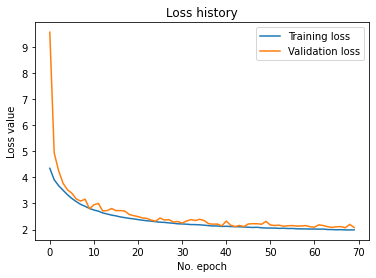

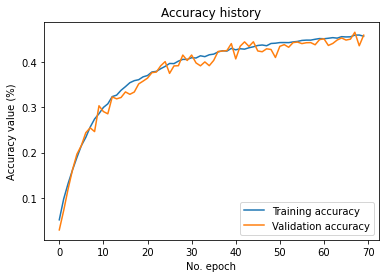

In [229]:
showAccandLossPlots(test_images, test_labels_fine)

Confiusion Matrix of Method 1, fine labels

313/313 [==============================] - 1s 2ms/step


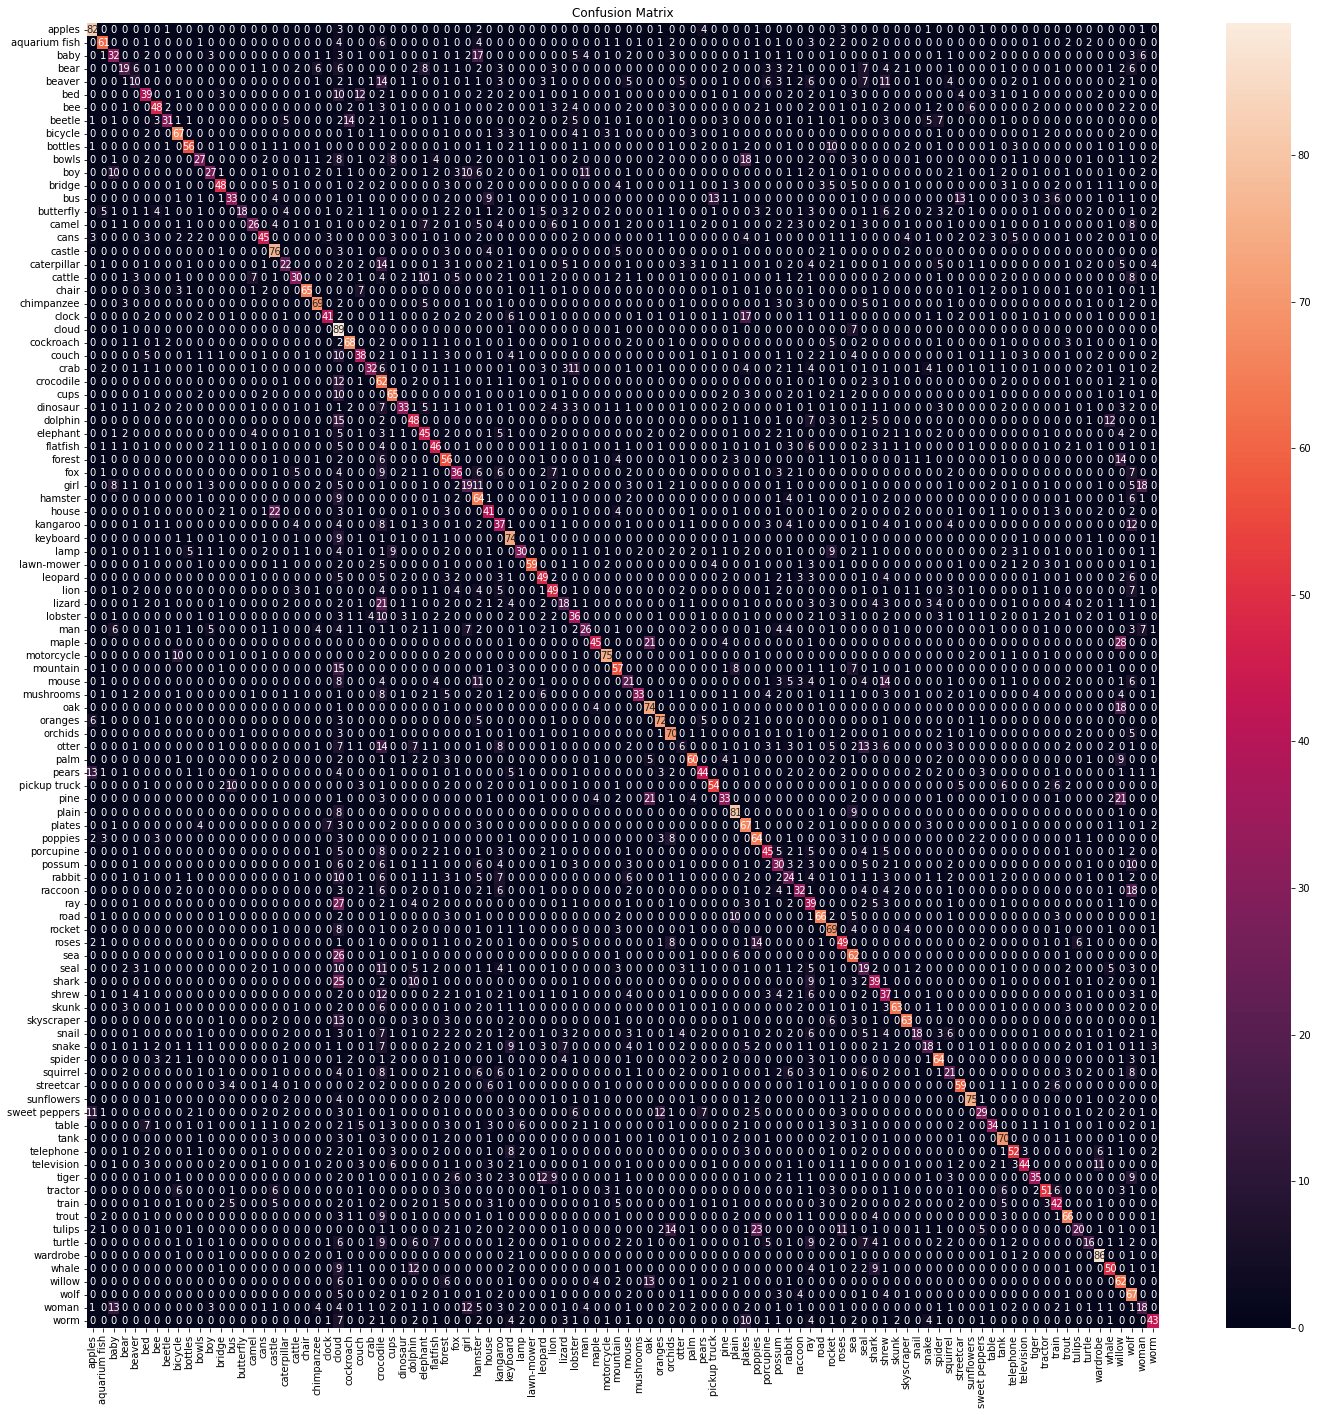

In [240]:
showHeatmap(test_images, test_labels_fine, 'fine_labels.csv', no_classes, (24, 24))

Few examples of images with annotations

313/313 [==============================] - 1s 2ms/step
[9846, 8209, 682, 3778, 2262, 8256, 6474, 5915, 318, 4065]


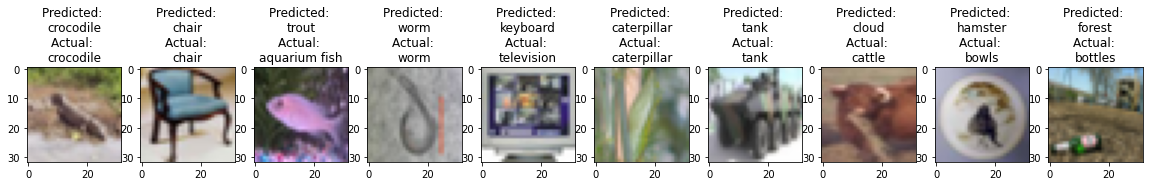

In [242]:
showsamples(test_labels_fine, test_images)

The same neural network for coarse labels


In [243]:
no_classes = 20

createConvolutionalNN()

In [244]:
# Compiling and training the model

model.compile(loss=loss_function,
              optimizer=optimizer,
              metrics=['accuracy'])

model.summary()

history = model.fit(train_images, train_labels_coarse,
            batch_size=batch_size,
            epochs=no_epochs,
            verbose=verbosity,
            validation_split=validation_split)

Model: "sequential_36"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_36 (Conv2D)          (None, 30, 30, 32)        896       
                                                                 
 dropout_124 (Dropout)       (None, 30, 30, 32)        0         
                                                                 
 batch_normalization_82 (Bat  (None, 30, 30, 32)       128       
 chNormalization)                                                
                                                                 
 conv2d_37 (Conv2D)          (None, 28, 28, 32)        9248      
                                                                 
 dropout_125 (Dropout)       (None, 28, 28, 32)        0         
                                                                 
 batch_normalization_83 (Bat  (None, 28, 28, 32)       128       
 chNormalization)                                    

Plots of Method 1, coarse labels

Test loss: 1.3763599395751953 / Test accuracy: 0.5738999843597412


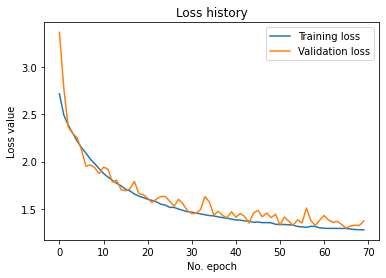

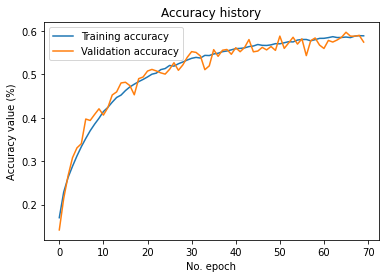

In [245]:
showAccandLossPlots(test_images, test_labels_coarse)

Confusion matrix of Method 1, coarse labels

313/313 [==============================] - 1s 2ms/step


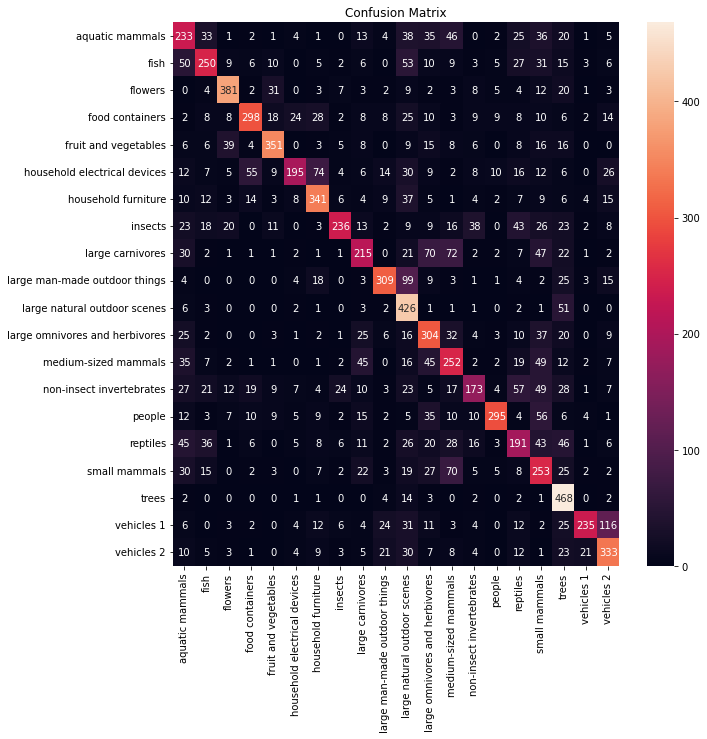

In [246]:
showHeatmap(test_images, test_labels_coarse, 'coarse_labels.csv', no_classes, (10, 10))

313/313 [==============================] - 1s 2ms/step
[9152, 7014, 4988, 9990, 4501, 3196, 6986, 4310, 1716, 1579]


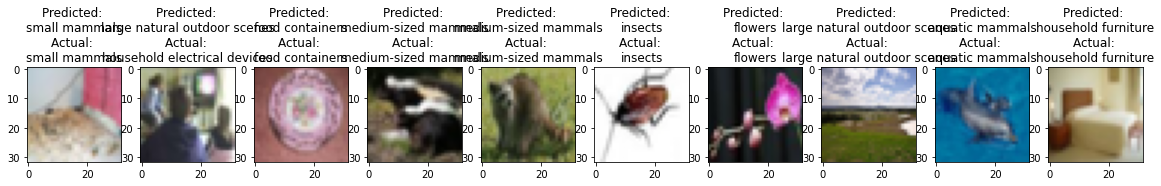

In [247]:
showsamples(test_labels_coarse, test_images)

In this section we are using convolutional neural network with features of Histogram of Oriented Gradients extracted:

In [248]:
#Extracting features from train and test images

train_features = []
train_images_hog = []
i = 0
for img in train_images:
  features, himg = skimage.feature.hog(img, pixels_per_cell=[5,5], cells_per_block=[5,5], visualize=True)
  train_features.append(features)
  train_images_hog.append(himg)

test_features = []
test_images_hog = []
for img in test_images:
  features, himg = skimage.feature.hog(img, pixels_per_cell=[5,5], cells_per_block=[5,5], visualize=True)
  test_features.append(features)
  test_images_hog.append(himg)

print(train_images.shape)


(50000, 32, 32, 3)


In [249]:
# Converting arrays of features into numpy arrays with correct shape
train_images_hog = np.array(train_images_hog)
test_images_hog = np.array(test_images_hog)

train_images_hog = np.reshape(train_images_hog, (50000, 32, 32, 1))
test_images_hog = np.reshape(test_images_hog, (10000, 32, 32, 1))

train_features = np.array(train_features)
test_features = np.array(test_features)

print(train_images_hog.shape)
print(test_images_hog.shape)
print(train_features.shape)
print(test_features.shape)

(50000, 32, 32, 1)
(10000, 32, 32, 1)
(50000, 900)
(10000, 900)


In [262]:
# Model configuration
img_width, img_height, img_num_channels = 32, 32, 1
input_shape = (img_width, img_height, img_num_channels)
no_classes = 100

createConvolutionalNN()

In [263]:
#Compiling and training the model

model.compile(loss=loss_function,
              optimizer=optimizer,
              metrics=['accuracy'])

model.summary()

history = model.fit(train_images_hog, train_labels_fine,
            batch_size=batch_size,
            epochs=no_epochs,
            verbose=verbosity,
            validation_split=validation_split)

Model: "sequential_41"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_56 (Conv2D)          (None, 30, 30, 32)        320       
                                                                 
 dropout_164 (Dropout)       (None, 30, 30, 32)        0         
                                                                 
 batch_normalization_102 (Ba  (None, 30, 30, 32)       128       
 tchNormalization)                                               
                                                                 
 conv2d_57 (Conv2D)          (None, 28, 28, 32)        9248      
                                                                 
 dropout_165 (Dropout)       (None, 28, 28, 32)        0         
                                                                 
 batch_normalization_103 (Ba  (None, 28, 28, 32)       128       
 tchNormalization)                                   

Plots of Method 2, fine labels

Test loss: 3.1258015632629395 / Test accuracy: 0.2615000009536743


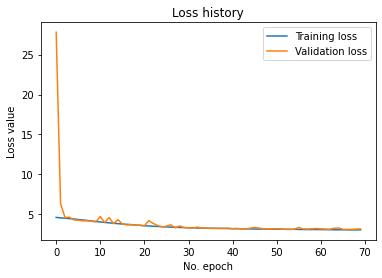

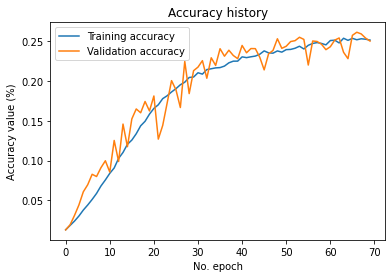

In [264]:
showAccandLossPlots(test_images_hog, test_labels_fine)

Confusion matrix of Method 2, fine labels

313/313 [==============================] - 1s 2ms/step


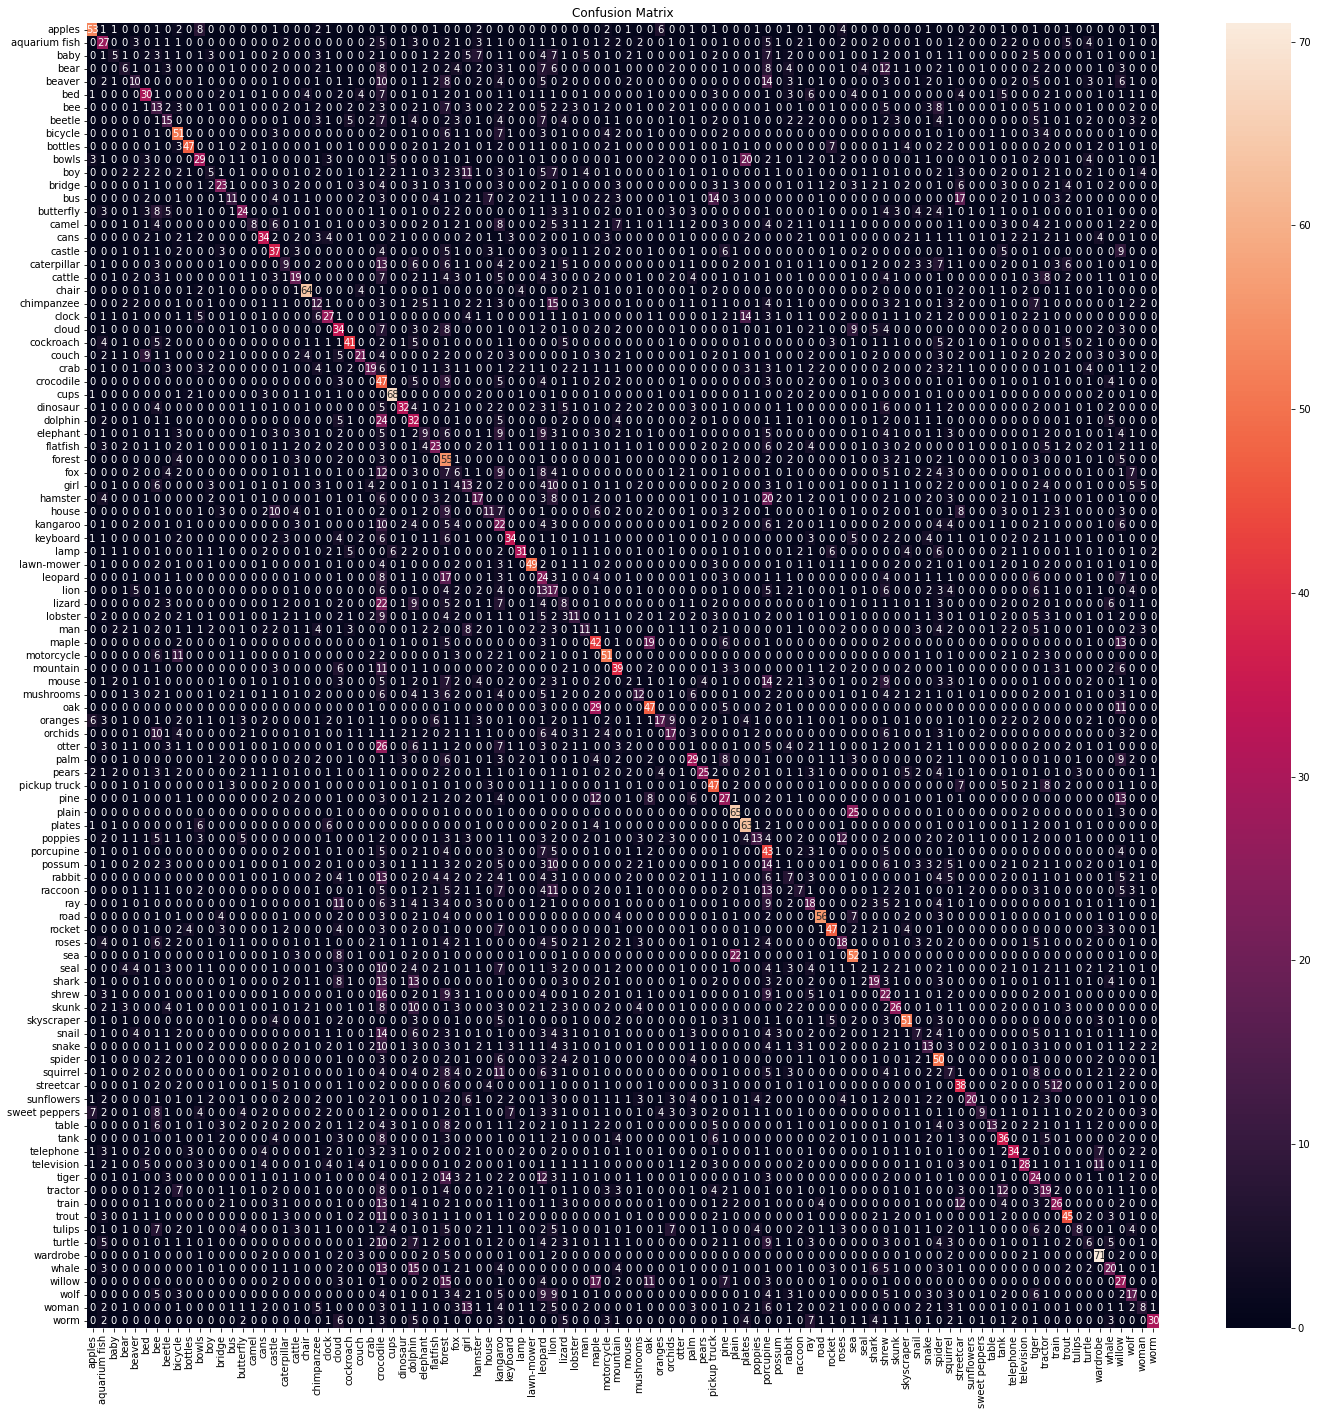

In [268]:
showHeatmap(test_images_hog, test_labels_fine, 'fine_labels.csv', no_classes, (24, 24))

313/313 [==============================] - 1s 2ms/step
[5457, 8207, 4778, 9931, 4705, 9735, 4786, 9747, 1221, 3462]


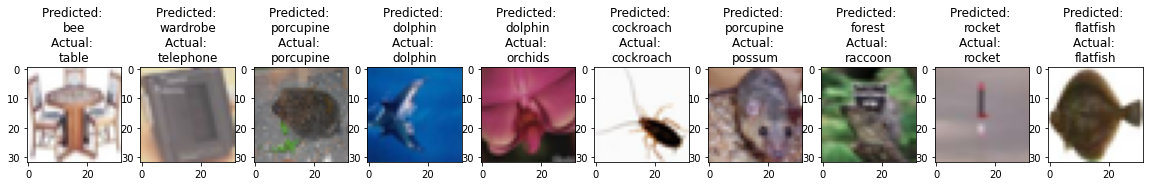

In [273]:
showsamples(test_labels_fine, test_images_hog)

The same neural network, but for coarse labels

In [284]:
no_classes = 20

createConvolutionalNN()

In [285]:
#Compiling and training the model

model.compile(loss=loss_function,
              optimizer=optimizer,
              metrics=['accuracy'])

model.summary()

history = model.fit(train_images_hog, train_labels_coarse,
            batch_size=batch_size,
            epochs=no_epochs,
            verbose=verbosity,
            validation_split=validation_split)

Model: "sequential_44"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_64 (Conv2D)          (None, 30, 30, 32)        320       
                                                                 
 dropout_182 (Dropout)       (None, 30, 30, 32)        0         
                                                                 
 batch_normalization_112 (Ba  (None, 30, 30, 32)       128       
 tchNormalization)                                               
                                                                 
 conv2d_65 (Conv2D)          (None, 28, 28, 32)        9248      
                                                                 
 dropout_183 (Dropout)       (None, 28, 28, 32)        0         
                                                                 
 batch_normalization_113 (Ba  (None, 28, 28, 32)       128       
 tchNormalization)                                   

Plots of Method 2, coarse labels

Test loss: 2.026538372039795 / Test accuracy: 0.3815999925136566


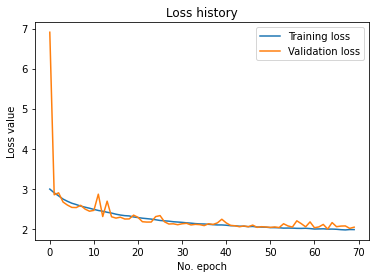

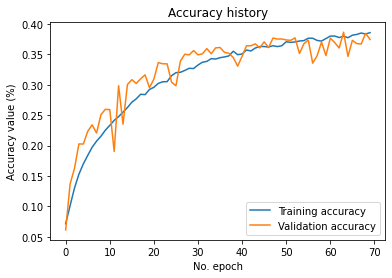

In [286]:
showAccandLossPlots(test_images_hog, test_labels_coarse)

Confusion matrix of Method 2, coarse labels

313/313 [==============================] - 1s 2ms/step


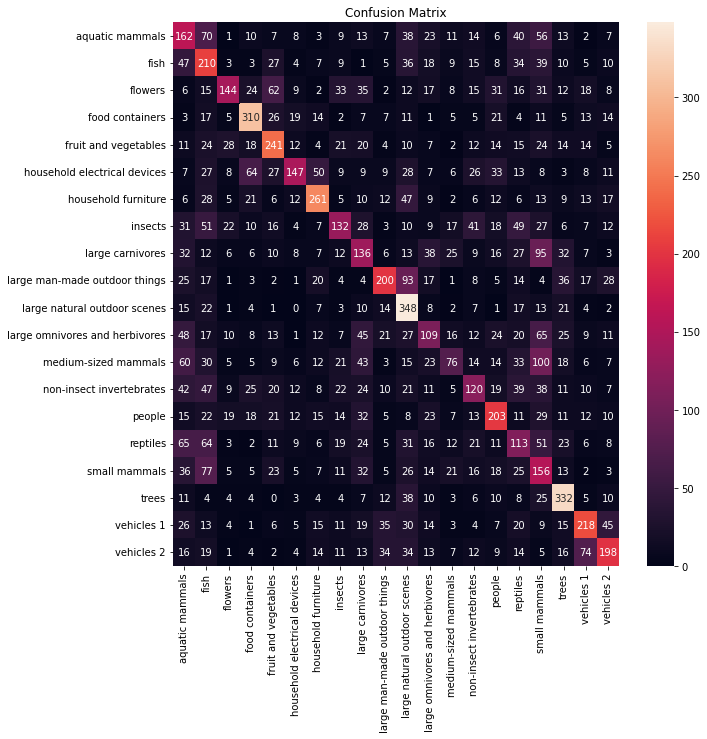

In [287]:
showHeatmap(test_images_hog, test_labels_coarse, 'coarse_labels.csv', no_classes, (10, 10))

313/313 [==============================] - 1s 2ms/step
[8323, 7331, 1451, 4853, 2867, 4165, 3160, 8164, 6784, 4014]


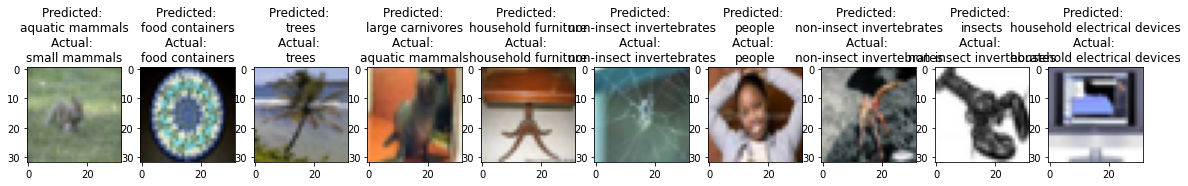

In [288]:
showsamples(test_labels_coarse, test_images_hog)

Neural network based purely on features extracted from Histogram of Oriented Gradients without convolution

In [293]:
no_classes = 100

model = Sequential()

model.add(tf.keras.layers.Dense(512, input_shape=(900,), activation='relu'))
model.add(tf.keras.layers.Dropout(0.25))
model.add(BatchNormalization())
model.add(tf.keras.layers.Dense(256, activation='relu'))
model.add(tf.keras.layers.Dropout(0.5))
model.add(BatchNormalization())
model.add(tf.keras.layers.Dense(no_classes, activation='softmax'))


In [294]:
#Compiling and training the model

model.compile(loss=loss_function,
              optimizer=optimizer,
              metrics=['accuracy'])

model.summary()

history = model.fit(train_features, train_labels_fine,
            batch_size=batch_size,
            epochs=40,
            verbose=verbosity,
            validation_split=validation_split)

Model: "sequential_45"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_112 (Dense)           (None, 512)               461312    
                                                                 
 dropout_190 (Dropout)       (None, 512)               0         
                                                                 
 batch_normalization_116 (Ba  (None, 512)              2048      
 tchNormalization)                                               
                                                                 
 dense_113 (Dense)           (None, 256)               131328    
                                                                 
 dropout_191 (Dropout)       (None, 256)               0         
                                                                 
 batch_normalization_117 (Ba  (None, 256)              1024      
 tchNormalization)                                   

Plots of Method 3, fine labels

Test loss: 3.3576788902282715 / Test accuracy: 0.23770000040531158


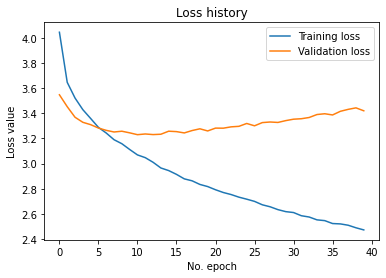

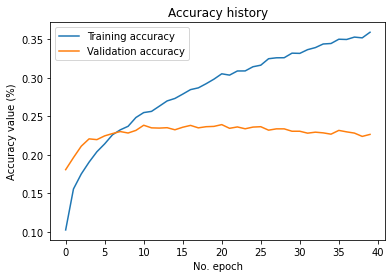

In [295]:
showAccandLossPlots(test_features, test_labels_fine)

Confusion matrix of Method 3, fine labels

313/313 [==============================] - 1s 2ms/step


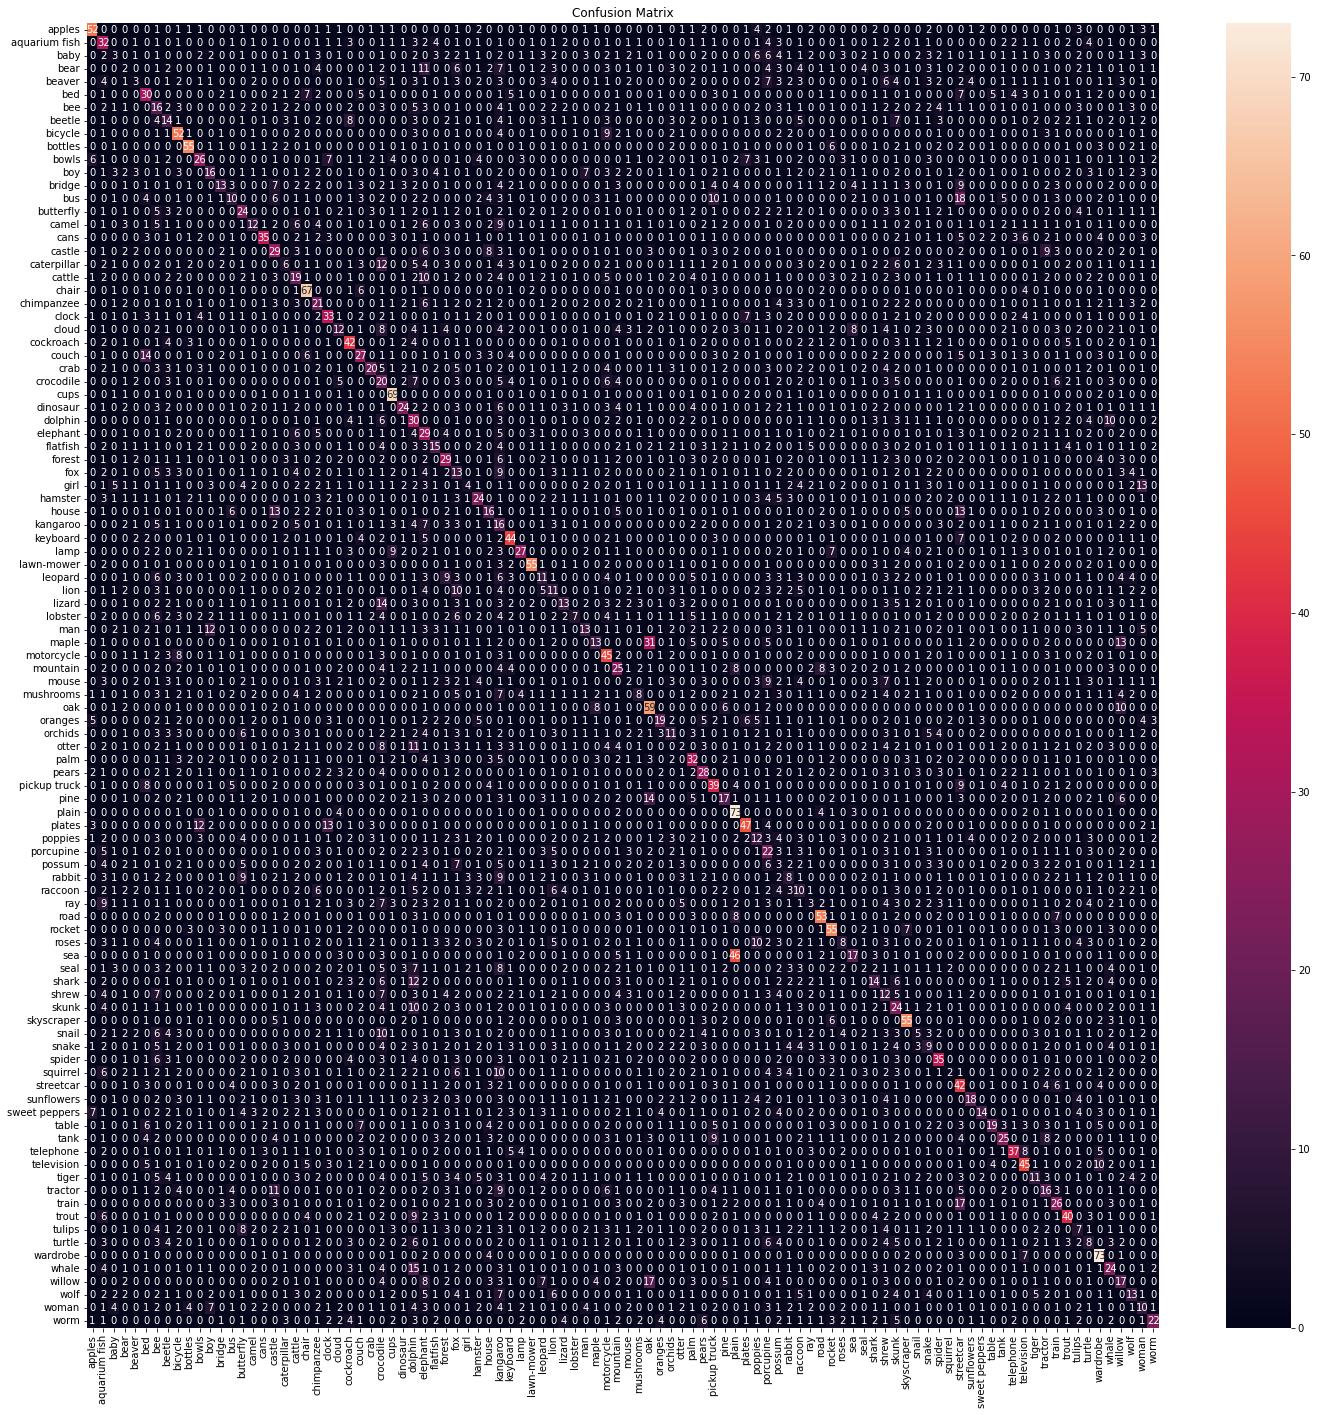

In [296]:
showHeatmap(test_features, test_labels_fine, 'fine_labels.csv', no_classes, (24, 24))

313/313 [==============================] - 1s 2ms/step
[3371, 1989, 9291, 6972, 3826, 5820, 218, 4455, 8968, 4100]


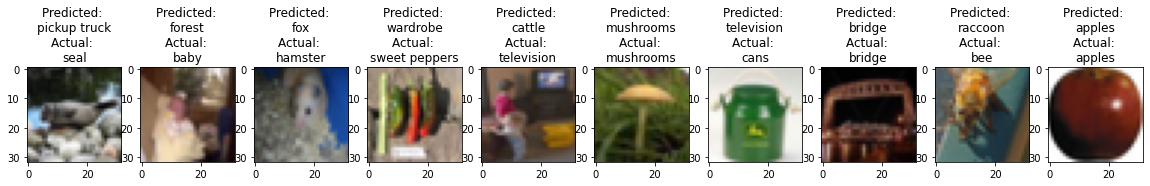

In [297]:
showsamples(test_labels_fine, test_features)

Almost the same network (one additional layer) but for coarse labels

In [303]:
no_classes = 20

model = Sequential()

model.add(tf.keras.layers.Dense(256, input_shape=(900,), activation='relu'))
model.add(BatchNormalization())
model.add(tf.keras.layers.Dropout(0.2))
model.add(BatchNormalization())
model.add(tf.keras.layers.Dense(128, activation='relu'))
model.add(BatchNormalization())
model.add(tf.keras.layers.Dropout(0.3))
model.add(tf.keras.layers.Dense(64, activation='relu'))
model.add(BatchNormalization())
model.add(tf.keras.layers.Dropout(0.4))
model.add(BatchNormalization())
model.add(tf.keras.layers.Dense(no_classes, activation='softmax'))


In [304]:
#Compiling and training the model

model.compile(loss=loss_function,
              optimizer=optimizer,
              metrics=['accuracy'])

model.summary()

history = model.fit(train_features, train_labels_coarse,
            batch_size=batch_size,
            epochs=40,
            verbose=verbosity,
            validation_split=validation_split)

Model: "sequential_48"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_123 (Dense)           (None, 256)               230656    
                                                                 
 batch_normalization_128 (Ba  (None, 256)              1024      
 tchNormalization)                                               
                                                                 
 dropout_198 (Dropout)       (None, 256)               0         
                                                                 
 batch_normalization_129 (Ba  (None, 256)              1024      
 tchNormalization)                                               
                                                                 
 dense_124 (Dense)           (None, 128)               32896     
                                                                 
 batch_normalization_130 (Ba  (None, 128)            

Plots of Method 3, coarse labels

Test loss: 2.163422107696533 / Test accuracy: 0.34369999170303345


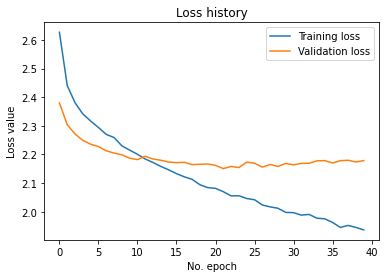

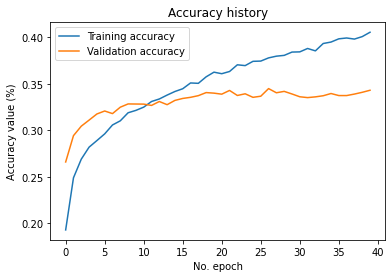

In [305]:
showAccandLossPlots(test_features, test_labels_coarse)

Confusion matrix of method 3, coarse labels

313/313 [==============================] - 1s 2ms/step


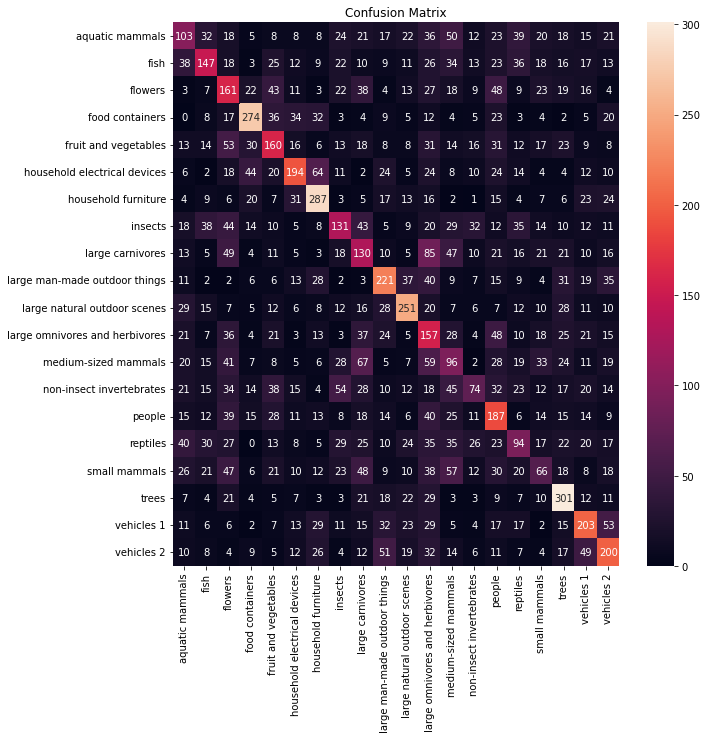

In [306]:
showHeatmap(test_features, test_labels_coarse, 'coarse_labels.csv', no_classes, (10, 10))

313/313 [==============================] - 1s 2ms/step
[6194, 2335, 5685, 4117, 5671, 846, 9632, 867, 9154, 476]


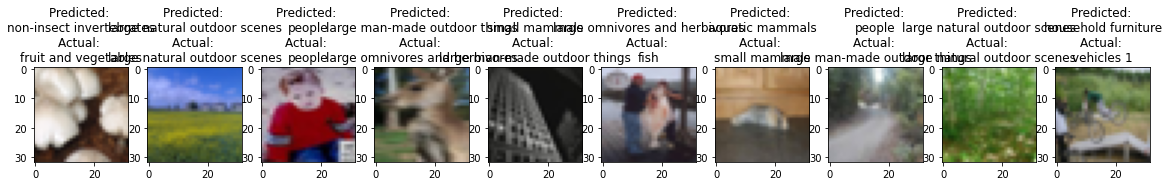

In [308]:
showsamples(test_labels_coarse, test_features)